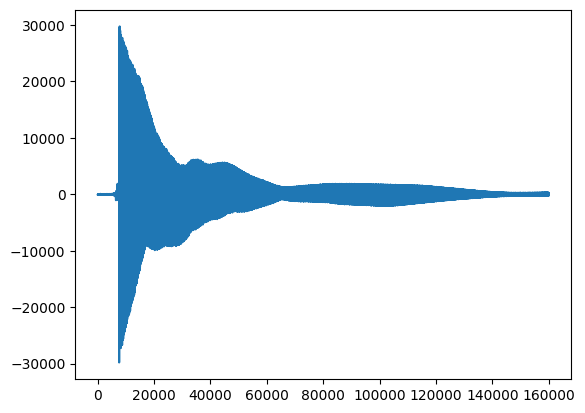

In [47]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read

samplerate, data = read("sounds/note_guitare_LAd.wav")
plt.plot(data)
plt.show()

plt.stem(np.abs(data))
plt.show()

In [ ]:
fft_spect = np.fft.rfft(data)
arr_freq = np.fft.rfftfreq(data.size, d=1./samplerate)
amp_fft_spect = np.abs(fft_spect)

amp_fft_spect /= np.max(amp_fft_spect)


plt.plot(amp_fft_spect)
plt.show()

print(np.argmax(amp_fft_spect))
print(arr_freq[np.argmax(amp_fft_spect)])

plt.plot(arr_freq, amp_fft_spect)

plt.xlim(0, 20000)
plt.show()

In [ ]:
# Aller chercher les 32 plus grosses amp et leur freq
N = 32
inx = np.argpartition(amp_fft_spect, -N)[-N:]
for i in inx:
    print(f"freq : {arr_freq[i]}, amp : {amp_fft_spect[i]}")

In [ ]:
# Frequences fondamentales
freq_fondamentale = 465.80625000000003 
freq_harmoniques = np.arange(freq_fondamentale, N*freq_fondamentale, freq_fondamentale)
print(freq_harmoniques) 

# Find nearest freq_harmoniques in freq
#  where is freq_f in freq ?
def find_nearest_idx(arr, val):
    arr = np.asarray(arr)
    return (np.abs(arr - val)).argmin()

nearest_freq_idx = find_nearest_idx(arr_freq, freq_harmoniques[0])
print(arr_freq[nearest_freq_idx])
print(amp_fft_spect[nearest_freq_idx])

# for f_h in freq_harmoniques:

